In [ ]:
# Calculating best spectral index

In [1]:
import os 
import numpy as np
import matplotlib as plt

In [ ]:
# calc NDSI, NDWI, NDVI

# already have NDSI

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDSI')
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDVI')
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDWI')

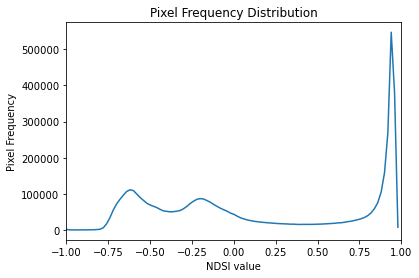

In [22]:
# plot pixel density distributions to find optimal thresholds
# a histogram is a graphical representation showing how frequently various color values occur in the image.

# https://datacarpentry.org/image-processing/05-creating-histograms/ 
"""
 * Generate a grayscale histogram for an image.
 *
 * Usage: python GrayscaleHistogram.py <fiilename>
"""
import sys
import numpy as np
import skimage.color
import skimage.io
from matplotlib import pyplot as plt
from imageio import imread


os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDSI')
image = imread('Alaska_NDSI.tif')


# plot as histogram
histogram, bin_edges = np.histogram(image, bins=100, range=(-1, 1)) # bins 256


# histogram 
plt.figure()
plt.title("Pixel Frequency Distribution")
plt.xlabel("NDSI value")
plt.ylabel("Pixel Frequency")
plt.xlim([-1.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

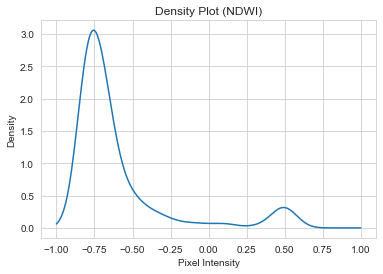

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/All_NDWI')

image = imread('Canada_NDWI.tif')

pixel = image[1]



#for pixel in image:
data = pixel #[2,3,3,4,2,1,5,6,4,3,3,3,6,4,5,4,3,2]
density = kde.gaussian_kde(data)

x = np.linspace(-1,1,400)
y=density(x)

plt.plot(x, y)
plt.title("Density Plot (NDWI)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.show()

In [154]:
# apply optimal thresholds for each index 
# minus the NDWI and NDVI from the NDSI to get the snow mask

import cv2
#import Image
from tifffile import imsave
from PIL import Image, ImageOps, ImageFilter


os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/France') 


NDSI = imread('France_NDSI.tif')
NDWI = imread('France_NDWI.tif')
NDVI = imread('France_NDVI.tif')


def to_mask(input_image, threshold):
    input_image[input_image <= threshold] = np.nan
    input_image[input_image > threshold] = 1
    return input_image
    
    
NDSI_mask = to_mask(NDSI, 0.35) # 0.35
NDWI_mask = to_mask(NDWI, 0.25) # 0.25
NDVI_mask = to_mask(NDVI, 0.20) # 0.20



NDWI_binary_mask = np.nan_to_num(NDWI_mask)
NDSI_binary_mask = np.nan_to_num(NDSI_mask)
NDVI_binary_mask = np.nan_to_num(NDVI_mask)



both = NDSI_binary_mask + NDWI_binary_mask  #+ NDVI_binary_mask #
snow_only = both.copy()
print("RRRR0 and 1", np.unique(snow_only, return_counts=True))
snow_only[snow_only == 2] = 0
print("...", np.unique(snow_only, return_counts=True))


img = Image.fromarray(snow_only) #.astype(np.uint8)


# save in SI snow mask folder
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/Snow_masks') 
outfile = "France_SI_snow_mask.tif"
img.save(outfile)



In [165]:
# calc iou
# https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation

# IoU = true positive / (true positive + false positive + false negative)

from sklearn.metrics import confusion_matrix  
import numpy as np



os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/Snow_masks') 
# SI pic
y_pred = imread('France_SI_snow_mask.tif')

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/LABELS')
# ground truth
y_true = imread('FR_bbox1_5.png') #/ 255) 

y_true = y_true/255
#print("unique", np.unique(y_true))


def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)


#compute_iou(y_pred, y_true)


# conf matrix
y_pred = y_pred.flatten()
y_true = y_true.flatten()
confusion_matrix(y_true, y_pred, labels=[0, 1])


# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 

# results:
# forested
# NZ miou: 0.9245122662473368
# CN miou: 0.5661474466421499
# france: 0.6621255835893318

#non-forested
# alaska: 0.7212450746880599
# argentina: 0.8189204859356305
# Norway: 0.8685089674657489



array([[5484154,   91941],
       [  38941,   69722]])

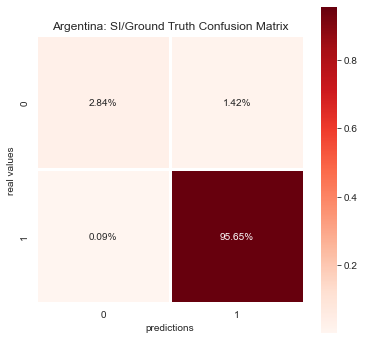

In [172]:
import seaborn as sns

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/SPECTRAL_INDEX/Snow_masks') 
# SI pic
Y_pred = imread('Argentina_SI_snow_mask.tif')

os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/FINAL/LABELS')
# ground truth
Y_val = imread('Arg_bbox3_2.png') #/ 255) 

Y_val = Y_val/255
#print("unique", np.unique(y_true))


FP = len(np.where(Y_pred - Y_val  == -1)[0])
FN = len(np.where(Y_pred - Y_val  == 1)[0])
TP = len(np.where(Y_pred + Y_val ==2)[0])
TN = len(np.where(Y_pred + Y_val == 0)[0])
cmat = [[TP, FN], [FP, TN]]

plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.title("Argentina: SI/Ground Truth Confusion Matrix")
plt.xlabel("predictions")
plt.ylabel("real values")
plt.show()